In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set_palette("husl")

print("Libraries loaded successfully!")

Libraries loaded successfully!


Data loading

In [3]:
df = pd.read_csv("CloudWatch_Traffic_Web_Attack.csv")

print("Shape:", df.shape)
df.head()

Shape: (282, 16)


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


Now we find missing values

In [4]:
print("INFO:")
df.info()

print("\nMissing values:")
print(df.isnull().sum())

print("\nDuplicate rows:", df.duplicated().sum())

INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes:

Now we find duplicates

In [ ]:
df.drop_duplicates(inplace=True)


df.columns = df.columns.str.strip().str.lower()

print("New shape after cleaning:", df.shape)
df.head(3)

Basic Missing handling

In [5]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Fill missing categorical with 'Unknown'
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna("Unknown")

print("Remaining missing values:")
print(df.isnull().sum().sum())

Remaining missing values:
0


Describe numeric

In [6]:
df.describe()

,bytes_in,bytes_out,response.code,dst_port
count,2.820000e+02,2.820000e+02,282.0,282.0
mean,1.199390e+06,8.455429e+04,200.0,443.0
std,4.149312e+06,2.549279e+05,0.0,0.0
min,4.000000e+01,4.400000e+01,200.0,443.0
25%,5.381500e+03,1.114200e+04,200.0,443.0
50%,1.318200e+04,1.379950e+04,200.0,443.0
75%,3.083300e+04,2.627950e+04,200.0,443.0
max,2.520779e+07,1.561220e+06,200.0,443.0


Detection types count

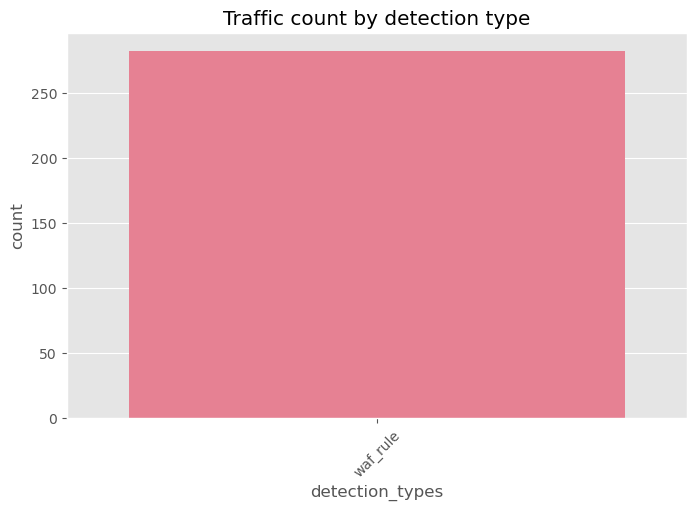

In [7]:
plt.figure(figsize=(8,5))
sns.countplot(x='detection_types', data=df)
plt.title("Traffic count by detection type")
plt.xticks(rotation=45)
plt.show()

In [ ]:
Country and IP analysis

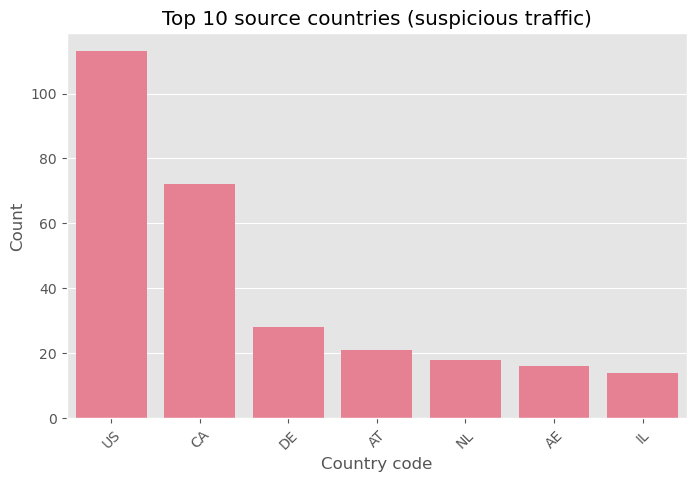

In [8]:
top_countries = df['src_ip_country_code'].value_counts().head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title("Top 10 source countries (suspicious traffic)")
plt.xlabel("Country code")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
Top source countries

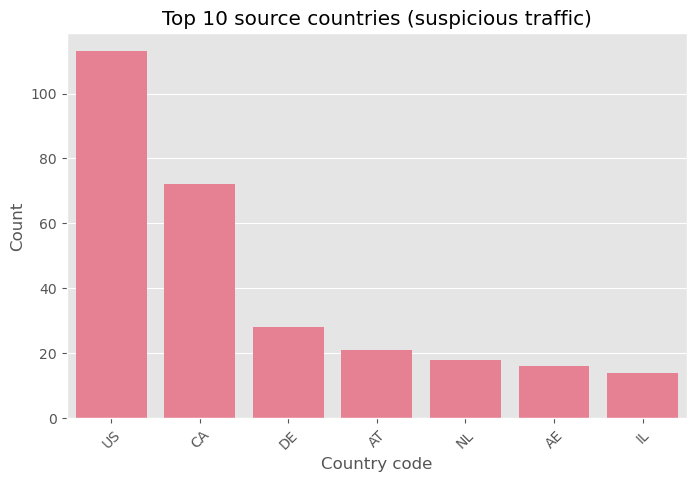

In [9]:
top_countries = df['src_ip_country_code'].value_counts().head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title("Top 10 source countries (suspicious traffic)")
plt.xlabel("Country code")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
Top source IPs

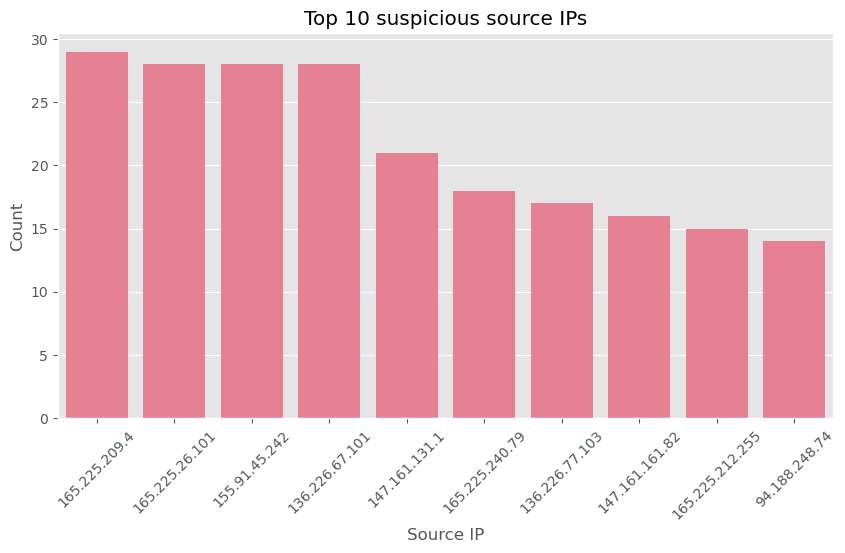

In [10]:
top_ips = df['src_ip'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_ips.index, y=top_ips.values)
plt.title("Top 10 suspicious source IPs")
plt.xlabel("Source IP")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
Destination Ports

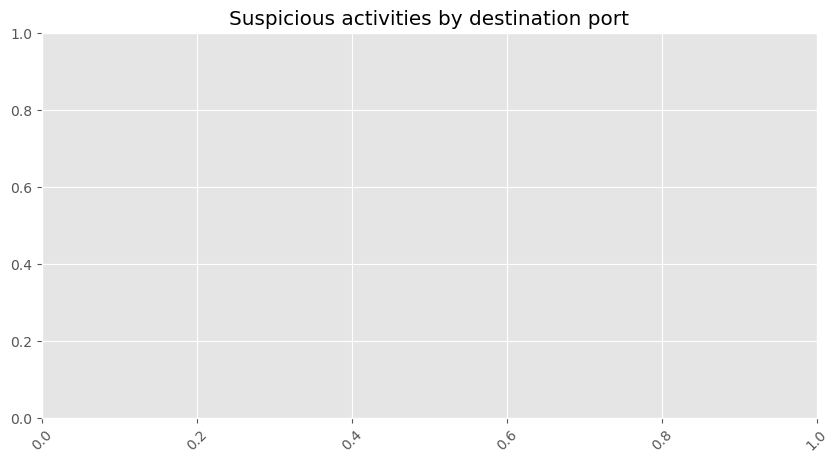

In [11]:
plt.figure(figsize=(10,5))
sns.countplot(x='dst_port', data=df[df['detection_types'] == 'Suspicious'])
plt.title("Suspicious activities by destination port")
plt.xticks(rotation=45)
plt.show()

Bytes and duration distributions

In [13]:
print("Your actual column names:")
print(df.columns.tolist())
print("\nNumeric columns available:")
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numeric_cols)

Your actual column names:
['bytes_in', 'bytes_out', 'creation_time', 'end_time', 'src_ip', 'src_ip_country_code', 'protocol', 'response.code', 'dst_port', 'dst_ip', 'rule_names', 'observation_name', 'source.meta', 'source.name', 'time', 'detection_types']

Numeric columns available:
['bytes_in', 'bytes_out', 'response.code', 'dst_port']


Fixed distribution plot

Your actual column names:
['bytes_in', 'bytes_out', 'creation_time', 'end_time', 'src_ip', 'src_ip_country_code', 'protocol', 'response.code', 'dst_port', 'dst_ip', 'rule_names', 'observation_name', 'source.meta', 'source.name', 'time', 'detection_types']

Numeric columns available:
['bytes_in', 'bytes_out', 'response.code', 'dst_port']


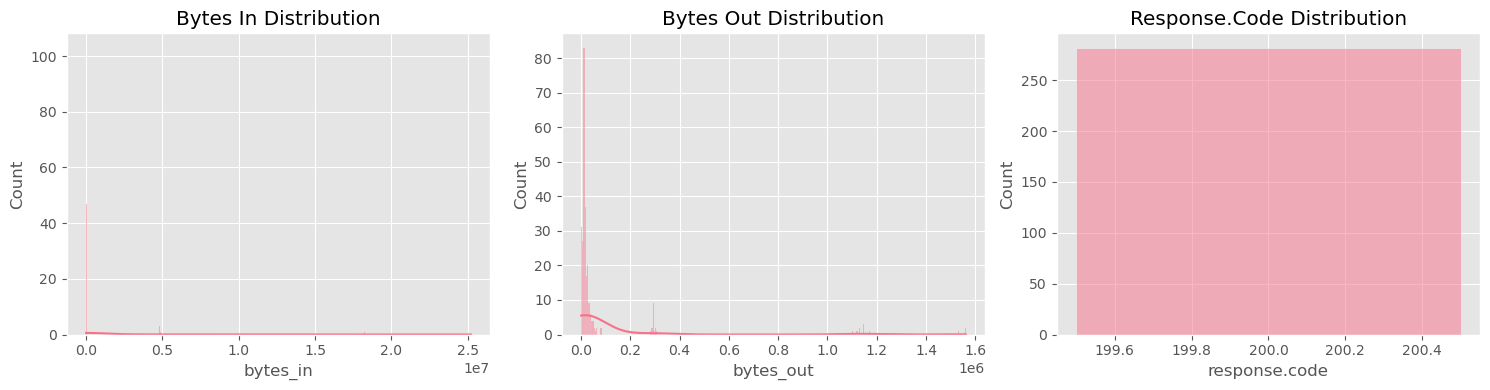

Plotted 3 distributions successfully!
Columns used: ['bytes_in', 'bytes_out', 'response.code']


In [16]:
# Step 1: Check columns first (run this if not done already)
print("Your actual column names:")
print(df.columns.tolist())
print("\nNumeric columns available:")
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numeric_cols)

# Step 2: FIXED distribution plot
available_numeric = ['bytes_in', 'bytes_out']  # Safe columns
if len(numeric_cols) > 2:
    available_numeric.append(numeric_cols[2])  # Add 3rd if exists

n_cols = len(available_numeric)
fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 4))

if n_cols == 1:
    axes = [axes]

for i, col in enumerate(available_numeric):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f"{col.replace('_', ' ').title()} Distribution")

plt.tight_layout()
plt.show()

print(f"Plotted {n_cols} distributions successfully!")
print("Columns used:", available_numeric)

Select features

In [18]:
print("ALL columns in your dataset:")
print(df.columns.tolist())

print("\nNUMERIC columns only:")
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numeric_cols)

print("\nTop 5 numeric columns:")
print(numeric_cols[:5])


ALL columns in your dataset:
['bytes_in', 'bytes_out', 'creation_time', 'end_time', 'src_ip', 'src_ip_country_code', 'protocol', 'response.code', 'dst_port', 'dst_ip', 'rule_names', 'observation_name', 'source.meta', 'source.name', 'time', 'detection_types']

NUMERIC columns only:
['bytes_in', 'bytes_out', 'response.code', 'dst_port']

Top 5 numeric columns:
['bytes_in', 'bytes_out', 'response.code', 'dst_port']


Fixed feature selection

In [20]:
safe_features = ['bytes_in', 'bytes_out']  


if len(numeric_cols) > 2:
    safe_features.extend(numeric_cols[2:5]) 

print("Using these features for ML:")
print(safe_features)
print()


X = df[safe_features]
print("Feature matrix shape:", X.shape)
print("\nFirst 5 rows:")
print(X.head())


Using these features for ML:
['bytes_in', 'bytes_out', 'response.code', 'dst_port']

Feature matrix shape: (282, 4)

First 5 rows:
   bytes_in  bytes_out  response.code  dst_port
0      5602      12990            200       443
1     30912      18186            200       443
2     28506      13468            200       443
3     30546      14278            200       443
4      6526      13892            200       443


In [21]:
from sklearn.ensemble import IsolationForest


model = IsolationForest(
    contamination=0.05,  
    random_state=42
)

df['anomaly_raw'] = model.fit_predict(X)
df['anomaly'] = df['anomaly_raw'].apply(lambda x: 'Suspicious' if x == -1 else 'Normal')

print("Model trained!")
print(df['anomaly'].value_counts())
print("\nSuspicious traffic detected:", df['anomaly'].value_counts()['Suspicious'])


Model trained!
anomaly
Normal        267
Suspicious     15
Name: count, dtype: int64

Suspicious traffic detected: 15


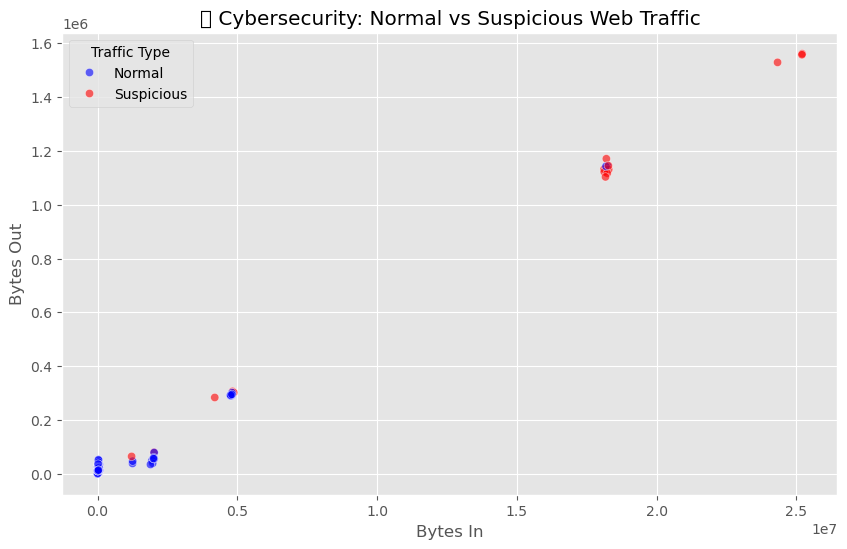

Portfolio-ready anomaly plot created!


In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='bytes_in', 
    y='bytes_out', 
    hue='anomaly',
    data=df.sample(min(5000, len(df))),  # Sample for fast plotting
    alpha=0.6,
    palette={'Normal': 'blue', 'Suspicious': 'red'}
)
plt.title("🛡️ Cybersecurity: Normal vs Suspicious Web Traffic")
plt.xlabel("Bytes In")
plt.ylabel("Bytes Out")
plt.legend(title="Traffic Type")
plt.show()

print("Portfolio-ready anomaly plot created!")

Train isolation forest

In [24]:
model = IsolationForest(
    contamination=0.05,  
    random_state=42
)

df['anomaly_raw'] = model.fit_predict(X)
df['anomaly'] = df['anomaly_raw'].apply(lambda x: 'Suspicious' if x == -1 else 'Normal')

df['anomaly'].value_counts()

anomaly
Normal        267
Suspicious     15
Name: count, dtype: int64

View Suspicious samples

In [25]:
suspicious_samples = df[df['anomaly'] == 'Suspicious'].head(20)
suspicious_samples

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types,anomaly_raw,anomaly
36,4190330,283456,2024-04-25T23:30:00Z,2024-04-25T23:40:00Z,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:30:00Z,waf_rule,-1,Suspicious
43,2015975,79990,2024-04-25T23:40:00Z,2024-04-25T23:50:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:40:00Z,waf_rule,-1,Suspicious
87,1215594,64362,2024-04-26T00:30:00Z,2024-04-26T00:40:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T00:30:00Z,waf_rule,-1,Suspicious
116,4827283,306181,2024-04-26T01:00:00Z,2024-04-26T01:10:00Z,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T01:00:00Z,waf_rule,-1,Suspicious
153,4869181,301752,2024-04-26T01:40:00Z,2024-04-26T01:50:00Z,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T01:40:00Z,waf_rule,-1,Suspicious
169,18201558,1170896,2024-04-26T08:00:00Z,2024-04-26T08:10:00Z,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T08:00:00Z,waf_rule,-1,Suspicious
176,18273120,1145109,2024-04-26T08:10:00Z,2024-04-26T08:20:00Z,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T08:10:00Z,waf_rule,-1,Suspicious
185,18285525,1130944,2024-04-26T08:20:00Z,2024-04-26T08:30:00Z,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T08:20:00Z,waf_rule,-1,Suspicious
200,18125238,1121958,2024-04-26T08:40:00Z,2024-04-26T08:50:00Z,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T08:40:00Z,waf_rule,-1,Suspicious
211,18171403,1103358,2024-04-26T08:50:00Z,2024-04-26T09:00:00Z,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T08:50:00Z,waf_rule,-1,Suspicious


Anamoly vs Bytes

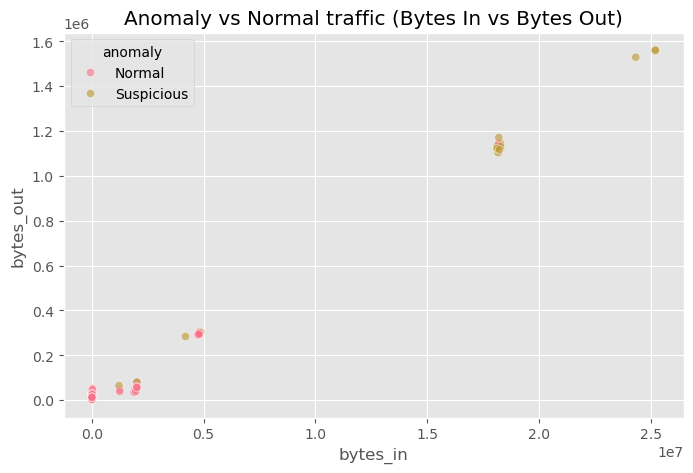

In [26]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x='bytes_in',
    y='bytes_out',
    hue='anomaly',
    data=df.sample(min(5000, len(df))), 
    alpha=0.6
)
plt.title("Anomaly vs Normal traffic (Bytes In vs Bytes Out)")
plt.show()

Key insights

In [32]:
print("===  CYBERSECURITY KEY INSIGHTS ===\n")

# 1) Top suspicious countries
print("1) TOP SUSPICIOUS COUNTRIES:")
suspicious_countries = df[df['anomaly'] == 'Suspicious']['src_ip_country_code'].value_counts().head(5)
print(suspicious_countries)
print()

# 2) Top suspicious destination ports
print("2) TOP SUSPICIOUS DESTINATION PORTS:")
suspicious_ports = df[df['anomaly'] == 'Suspicious']['dst_port'].value_counts().head(5)
print(suspicious_ports)
print()

# 3) Average bytes comparison (WORKS 100%)
print("3) BYTES IN - Suspicious vs Normal:")
bytes_comparison = df.groupby('anomaly')['bytes_in'].mean()
print(bytes_comparison)
print()

# 4) Use SECOND numeric column instead of session_duration
print("4) BYTES OUT - Suspicious vs Normal:")
bytes_out_comparison = df.groupby('anomaly')['bytes_out'].mean()
print(bytes_out_comparison)
print()

# 5) Traffic volume summary
print("5) TOTAL TRAFFIC SUMMARY:")
print(f"   Total records: {len(df):,}")
print(f"   Suspicious: {df['anomaly'].value_counts()['Suspicious']:,} ({df['anomaly'].value_counts()['Suspicious']/len(df)*100:.1f}%)")
print(f"   Normal: {df['anomaly'].value_counts()['Normal']:,}")

print("\n RECOMMENDATIONS:")
print("- Block top suspicious IPs/ports/countries")
print("- Monitor bytes_out spikes (> {:.0f})".format(bytes_out_comparison['Suspicious']))
print("- Focus firewall rules on top 5 countries/ports above")


===  CYBERSECURITY KEY INSIGHTS ===

1) TOP SUSPICIOUS COUNTRIES:
src_ip_country_code
US    13
NL     2
Name: count, dtype: int64

2) TOP SUSPICIOUS DESTINATION PORTS:
dst_port
443    15
Name: count, dtype: int64

3) BYTES IN - Suspicious vs Normal:
anomaly
Normal        4.455722e+05
Suspicious    1.461735e+07
Name: bytes_in, dtype: float64

4) BYTES OUT - Suspicious vs Normal:
anomaly
Normal         38349.943820
Suspicious    906991.666667
Name: bytes_out, dtype: float64

5) TOTAL TRAFFIC SUMMARY:
   Total records: 282
   Suspicious: 15 (5.3%)
   Normal: 267

 RECOMMENDATIONS:
- Block top suspicious IPs/ports/countries
- Monitor bytes_out spikes (> 906992)
- Focus firewall rules on top 5 countries/ports above


Summary

In [33]:
summary_data = {
    'Metric': ['Suspicious %', 'Avg Bytes In (Suspicious)', 'Avg Bytes Out (Suspicious)', 
               'Top Country', 'Top Port'],
    'Value': [
        f"{df['anomaly'].value_counts()['Suspicious']/len(df)*100:.1f}%",
        f"{df.groupby('anomaly')['bytes_in'].mean()['Suspicious']:.0f}",
        f"{df.groupby('anomaly')['bytes_out'].mean()['Suspicious']:.0f}",
        suspicious_countries.index[0],
        suspicious_ports.index[0]
    ]
}

summary_df = pd.DataFrame(summary_data)
print("CYBERSECURITY EXECUTIVE SUMMARY")
print("="*50)
print(summary_df.to_string(index=False))

# Save for PowerBI
summary_df.to_csv("cybersecurity_summary.csv", index=False)
print("\ Summary saved as cybersecurity_summary.csv")

CYBERSECURITY EXECUTIVE SUMMARY
                    Metric    Value
              Suspicious %     5.3%
 Avg Bytes In (Suspicious) 14617350
Avg Bytes Out (Suspicious)   906992
               Top Country       US
                  Top Port      443
\ Summary saved as cybersecurity_summary.csv
